# **CS357000 Introduction to Multimedia - HW2**

In this homework:  

You need to design and apply different FIR filters in to separate three audio signals from the given audio file (HW2_Mix.wav).  

Next, you are asked to reduce the sampling rates of filtered signals.  

Finally, since the output audio signals are too simple, so you should apply one-fold echo and multiple-fold echo (slide #65) to produce more complex music.  

Here's the steps:
1. Transform the input signal into frequency domain and plot the spectrum (magnitude in spectrum should be normalized to [0, 1]).
2. Implement 3 different FIR filters to separate the three audio signals with Blackman window function (You have to pick the appropriate filter size, cut-off frequency, and window size). 
3. Implement 1D convolution on the input signal with your filters (zero padding).
4. Reduce the sampling rates of the three separated songs to 2000Hz.
5. Apply one-fold echo and multiple-fold echo on the signal that pass through the **low-pass filter**. (Please use the audio files before reducing sampling rates)

# **Submission**
+ Submit HW2_yourID_yourName.zip to eeclass before the deadline (4/16). File structure as follows:
+ HW2_yourID_yourName (directory)
    + output (directory)
      + Band_pass_XXX_XXX_2khz.wav
      + Band_pass_XXX_XXX.wav
      + echo_multiple.wav
      + echo_one.wav
      + High_pass_XXX_2khz.wav
      + High_pass_XXX.wav
      + Low_pass_XXX_2khz.wav
      + Low_pass_XXX.wav
    + src (directory)
      + HW2_Mix.wav
    + HW2_yourID_yourName.ipynb
+ For image, direct show them in jupyter notebook (see main())

In [52]:
# !pip install numpy matplotlib scipy tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from numpy.fft import fft, fftfreq
from tqdm import tqdm, trange

## 1. FFT & Plot Spectrum (15%)
+ In this part, You should output 1 image showing the spectrum of the original signal

In [53]:
def plot_spectrum(input_signal, fs, xbound, ybound, title):
    '''
    Input: 
        input_signal: input signal (time-domain)
        fs: sampling frequency
        xbound: x-axis bound
        ybound: y-axis bound
        title: title of the plot
    '''
    # TODO: FFT & Plot the magnitude spectrum of the input signal
    X = fft(input_signal)
    freq = fftfreq(input_signal.size, d=1/fs)
    X = np.abs(X)
    freq = freq[freq >= 0]
    X = X[0:freq.size]
    plt.plot(freq, X/np.max(X))

    plt.xlim(xbound[0], xbound[1])
    plt.ylim(ybound[0], ybound[1])
    plt.xlabel('frequency')
    plt.ylabel('magnitude')
    plt.title(title)
    plt.show()

## 2. Filter Design (25%)
+ In this part, you should output 6 images showing the **shape** and **spectrum** of three types of filters.

In [54]:
def filter(fs, N, windowType, filterType, fc):
    '''
    Input: 
        fs: sampling frequency
        N: filter length (number of points in a filter), also the window length
        windowType: window function type (Blackman)
        filterType: filter type (Low-pass, High-pass, Band-pass)
        fc: cutoff frequency
    Output:
        myFilter: low-pass, high-pass, or band-pass filter
    '''
    fc = fc/fs
    mid = np.floor(N/2).astype(int)
    samplepts = np.arange((-mid) , mid+1)
    samplepts[mid] = 1  ## prevent divide by 0
    myFilter = np.zeros(2 * mid + 1)

    if filterType == 'Low-pass':
        # TODO: Implement the Low-pass filter
        myFilter = np.sin(samplepts*2*np.pi*fc)/(np.pi*samplepts)
        myFilter[mid] = 2*fc
        
    elif filterType == 'High-pass':
        # TODO: Implement the High-pass filter
        myFilter = -np.sin(samplepts*2*np.pi*fc)/(np.pi*samplepts)
        myFilter[mid] = 1-2*fc

    elif filterType == 'Band-pass':
        # TODO: Implement the Band-pass filter
        fc1, fc2 = fc[0], fc[1]
        myFilter = np.sin(2*np.pi*fc2*samplepts)/(np.pi*samplepts) - np.sin(2*np.pi*fc1*samplepts)/(np.pi*samplepts)
        myFilter[mid] = 2*(fc2-fc1)
     
    if windowType == 'Blackman':
        # TODO: Implement Blackman window function 
        samplepts = np.arange(0, N)
        myFilter = myFilter*(0.42-0.5*np.cos((2*np.pi*samplepts)/N)+0.08*np.cos((4*np.pi*samplepts)/N))
    return myFilter

In [55]:
def plot_filter(filter, title):
    
    plt.figure() 
    plt.plot(filter)
    plt.title(title)
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.show()

## 3. Convolution (15%)
+ In this part, you should output 3 images, each showing the result of the signal filtered by a different type of filter.

In [56]:
def convolve(signal, filter, N):
    '''
    Input: 
        signal: input signal (time-domain)
        filter: your filter
        N: filter length (number of points in a filter)
    Output:
        out: output signal (time-domain)
    '''
    len_signal = len(signal)
    out = np.zeros(len_signal)
    
    #TODO: Implement the 1D convolution operation
    for n in range(len_signal):

        if n >= N:
            x = signal[n:n-N:-1]
        else:
            x = np.zeros(N)
            x[0:n+1] = signal[n::-1]
        out[n] = np.sum(np.dot(filter, x))
    out = out.astype(np.float32)
    
    return out

## 4. Reduce sample rate (10%)

In [57]:
def down_sampling(signal, fs, new_fs):
    '''
    Input:
        signal: input signal (time-domain)
        fs: sampling frequency
        new_fs: new sampling frequency  
    Output:
        signal: down-sampled signal (time-domain)
    '''
    #TODO: Implement the down-sampling operation
    len_signal = signal.shape[0]
    interval = np.floor(fs/new_fs) 
    sample_idx = np.array([i*interval for i in range(int(np.floor(len_signal/interval)))]).astype(int)
    signal = signal[sample_idx]
    return signal

## 5. Echo (15%)

In [58]:
def echo(signal_low, delay, alpha, fs):
    '''
    Input:
        signal_low: input signal (time-domain)
        delay: delay time
        alpha: attenuation factor
        fs: sampling frequency
    Output:
        output_echo_one: output signal with one-fold echo
        output_echo_multiple: output signal with multiple-fold echo
    '''

    D = int(delay * fs)
    input_len = len(signal_low)
    output_echo_one = np.zeros(input_len + D)
    
    #TODO: One-fold echo
    output_echo_one[0:input_len] += signal_low
    output_echo_one[D:input_len+D] += alpha*signal_low

    D = int(delay * fs)
    input_len = len(signal_low)
    output_echo_multiple = np.zeros(input_len + D)
    
    #TODO: Multiple-fold echo
    for i in range(D):
        output_echo_multiple[i] = signal_low[i]
    for i in range(D, input_len):
        output_echo_multiple[i] = signal_low[i]+output_echo_multiple[i-D]
    for i in range(input_len, input_len+D):
        output_echo_multiple[i] = output_echo_multiple[i-D]

    output_echo_one = output_echo_one.astype(np.float32)
    output_echo_multiple = output_echo_multiple.astype(np.float32) 
    
    return  output_echo_one, output_echo_multiple

+ There should be 10 images displayed below the cell containing the main function.

C:\Users\ryan2\AppData\Local\Temp\ipykernel_17872\1004699456.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, input_signal = wav.read(audio)


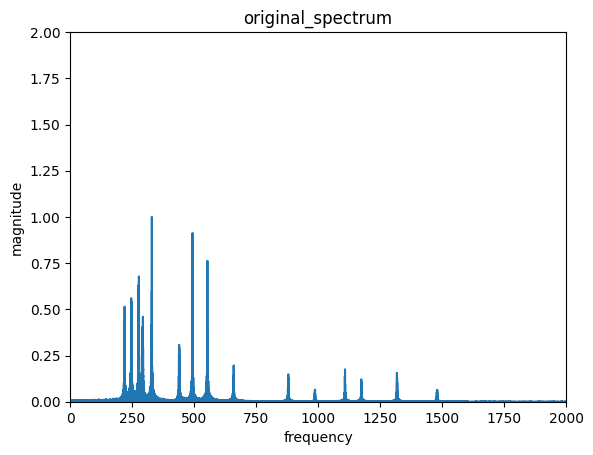

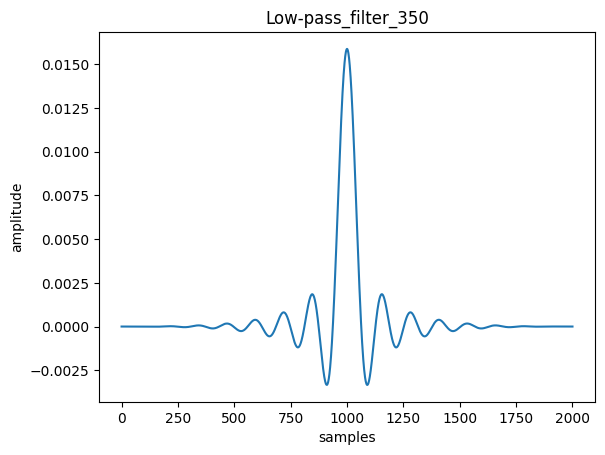

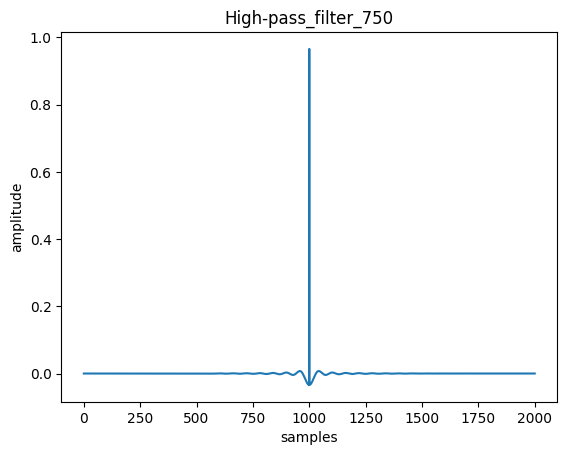

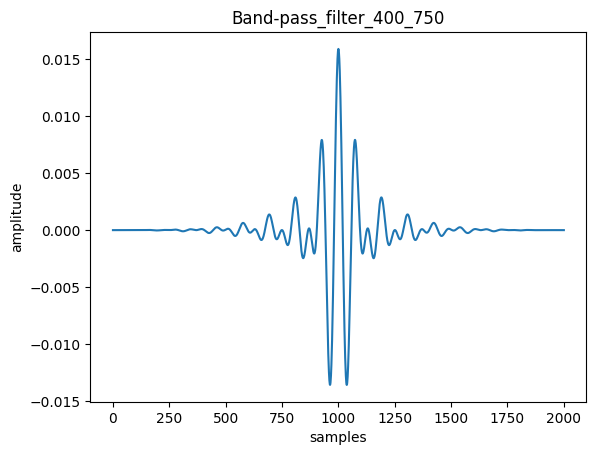

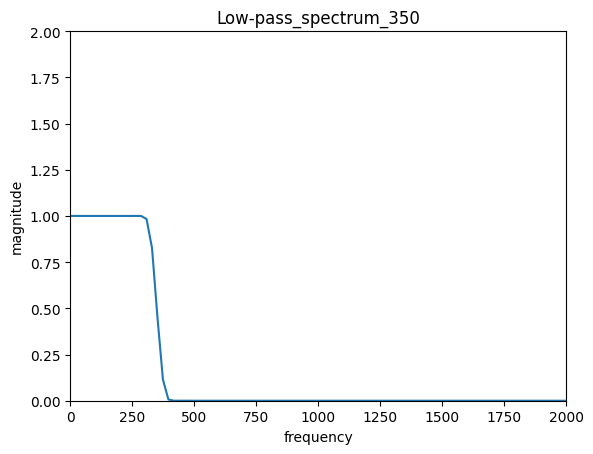

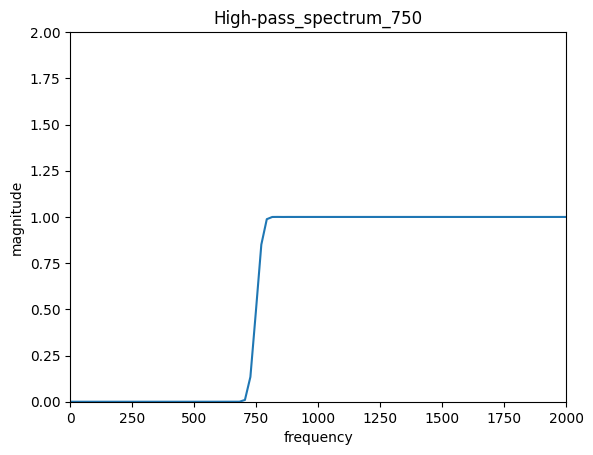

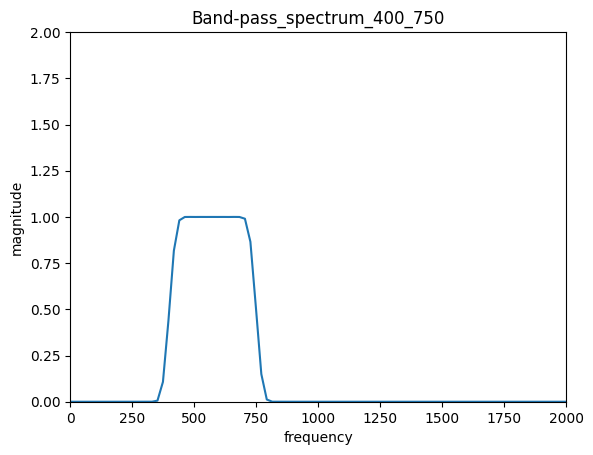

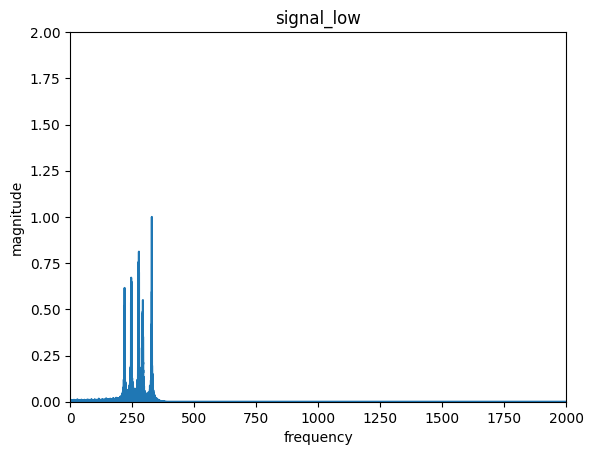

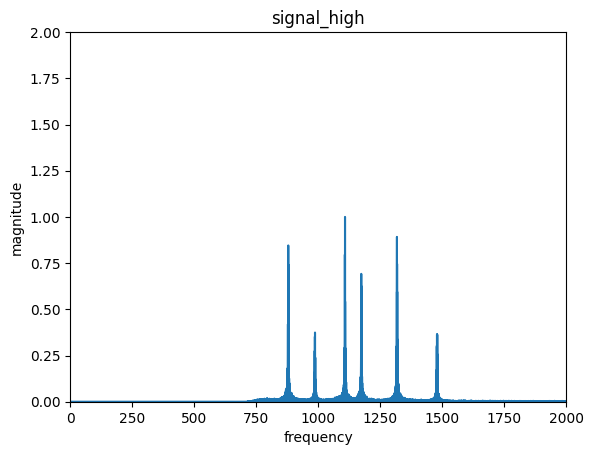

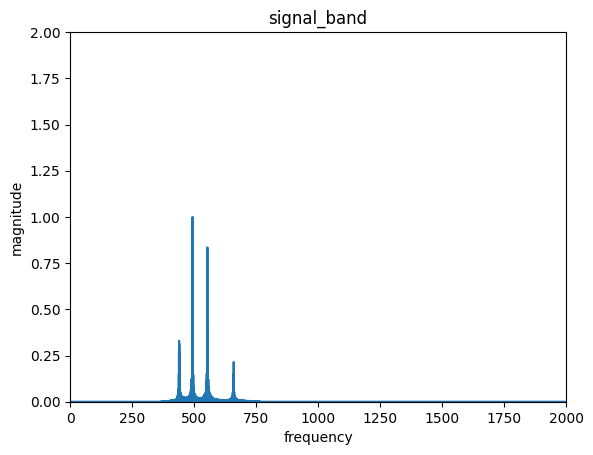

In [59]:
def main():
    audio = "./src/HW2_Mix.wav"
    fs, input_signal = wav.read(audio)

    # 1. Plot the magnitude spectrum of the input signal
    plot_spectrum(input_signal, fs, [0, 2000], [0, 2], "original_spectrum")

    # 2. implement filter
    #TODO: determine the cutoff frequency and window size
    windowType = "Blackman"
    fc_low = 350
    fc_high = 750
    fc_band = np.array([400, 750])
    filterSize = 2001

    # create filters
    lowpassFilter = filter(fs, N=filterSize, windowType=windowType, filterType='Low-pass', fc=fc_low)
    highpassFilter = filter(fs, N=filterSize, windowType=windowType, filterType='High-pass', fc=fc_high)
    bandpassFilter = filter(fs, N=filterSize, windowType=windowType, filterType='Band-pass', fc=fc_band)

    # plot filter shape and spectrum
    plot_filter(lowpassFilter, f"Low-pass_filter_{fc_low}")
    plot_filter(highpassFilter, f"High-pass_filter_{fc_high}")
    plot_filter(bandpassFilter , f"Band-pass_filter_{fc_band[0]}_{fc_band[1]}")
    plot_spectrum(lowpassFilter, fs, [0, 2000], [0, 2], f"Low-pass_spectrum_{fc_low}")
    plot_spectrum(highpassFilter, fs, [0, 2000], [0, 2], f"High-pass_spectrum_{fc_high}")
    plot_spectrum(bandpassFilter, fs, [0, 2000], [0, 2], f"Band-pass_spectrum_{fc_band[0]}_{fc_band[1]}")
    
    # 3. Convolve the input signal with the filters
    signal_low = convolve(input_signal, lowpassFilter, N=filterSize)
    signal_high = convolve(input_signal, highpassFilter, N=filterSize)
    signal_band = convolve(input_signal, bandpassFilter, N=filterSize)

    # save audio
    wav.write(f"output/Low_pass_{fc_low}.wav", fs, signal_low)
    wav.write(f"output/High_pass_{fc_high}.wav", fs, signal_high)
    wav.write(f"output/Band_pass_{fc_band[0]}_{fc_band[1]}.wav", fs, signal_band)

    # plot output spectrum
    plot_spectrum(signal_low, fs, [0,2000], [0,2], "signal_low")
    plot_spectrum(signal_high, fs, [0,2000], [0,2], "signal_high")
    plot_spectrum(signal_band, fs, [0,2000], [0,2], "signal_band")

    # 4. Reduce sample rate
    new_fs = 2000
    signal_low_ds = down_sampling(signal_low, fs, new_fs)
    signal_high_ds = down_sampling(signal_high, fs, new_fs)
    signal_band_ds = down_sampling(signal_band, fs, new_fs)

    # plot_spectrum(signal_low_ds, new_fs, [0,2000], [0,2], "signal_low")
    # plot_spectrum(signal_high_ds, new_fs, [0,2000], [0,2], "signal_high")
    # plot_spectrum(signal_band_ds, new_fs, [0,2000], [0,2], "signal_band")

    # # plot output spectrum DEBUG
    # plot_filter(signal_band[100000:100300], "test1")
    # plot_filter(signal_band_ds[100000:100300], "test2")

    # You can also try setting 'new_fs' as 'fs' to see what happens.
    wav.write(f"output/Low_pass_{fc_low}_2khz.wav", new_fs, signal_low_ds) 
    wav.write(f"output/High_pass_{fc_high}_2khz.wav", new_fs, signal_high_ds) 
    wav.write(f"output/Band_pass_{fc_band[0]}_{fc_band[1]}_2khz.wav", new_fs, signal_band_ds) 

    # 5. Echo
    echo_one , echo_multiple = echo(signal_low, 1, 0.5, fs)
    wav.write('output/echo_one.wav', fs, echo_one)
    wav.write("output/echo_multiple.wav", fs, echo_multiple)

if __name__ == "__main__":
    main()


## 6. Report (20%)
Your report should cover the following aspects(each 5%):
- Describe how you implemented the filter and convolutions to separate the mixed song. And how did you determine the filter size and cut-off frequency?
- Compare the spectrum and shape of the filters.
- Compare the differences between the signals before and after reducing the sampling rates.
- How did you implement one/multiple fold echo?